# **Portrait Colorization with Autoencoders**

This mini project is about portrait colorization using autoencoder architecture.

Dataset: 900 images from http://vis-www.cs.umass.edu/lfw/

It's based on @bnsreenu tutorial. Main purpose was to get along with new architecture.

**TPU setting**

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.6.0
Running on TPU  ['10.112.151.10:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.112.151.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.112.151.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


**Imports**

In [2]:
import tensorflow as tf
import numpy as np
import cv2 as cv
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow import device
import time
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping


**Useful functions**

In [3]:

def plot_history(history, save=True):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('epochs')
    plt.ylabel('value')
    plt.legend()
    if save:
        plt.savefig('accuracy5.png')
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('epochs')
    plt.ylabel('value')
    plt.legend()
    if save:
        plt.savefig('loss5.png')
    plt.show()

def load_images(path, grey=False, lab=False):
    images = []
    names = [n[2] for n in os.walk(path)]
    names = names[0]
    for name in names:
        if grey:
            images.append(cv.imread(path + name, 0))
        elif lab:
            img = cv.imread(path + name)
            img = rgb2lab(img)
            images.append(img)
    return images


def rescale(data, grey=False, lab=False):
    if grey:
        for i in range(len(data)):
            data[i] = data[i] / 255
    elif lab:
        for i in range(len(data)):
            data[i][:, :, 0] = data[i][:, :, 0] / 100
            data[i][:, :, 1:] = data[i][:, :, 1:] / 128
    return data

**Autoencoder setup**

It's based on @bnsreenu code. I've played with architecture a little bit and made some changes like additional layers in the middle, dropout and adjust batch size and epochs for this setup. I've also checked out batch normalization and learning scheduling but it didn't give me good results.

In [13]:
with tpu_strategy.scope():

  path = 'im/'

  train_datagen = ImageDataGenerator(rescale=1. / 255)

  train = train_datagen.flow_from_directory(path,
                                            target_size=(256, 256),
                                            batch_size=900,
                                            class_mode=None)

  X = []
  Y = []
  for img in train[0]:
      try:
          lab = rgb2lab(img)
          X.append(lab[:, :, 0])
          Y.append(lab[:, :, 1:] / 128)  
      except:
          print('error')
  X = np.array(X)
  Y = np.array(Y)
  X = X.reshape(X.shape + (1,))
  print(X.shape)
  print(Y.shape)

  dropout = 0.25

  # Encoder

  model = Sequential()

  model.add(Conv2D(64, (3, 3), padding='same', input_shape=(256, 256, 1)))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(dropout))

  model.add(Conv2D(128, (3, 3), padding='same', strides=2))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(dropout))

  model.add(Conv2D(128, (3, 3), padding='same'))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(dropout))

  model.add(Conv2D(256, (3, 3), padding='same', strides=2))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(dropout))

  model.add(Conv2D(256, (3, 3), padding='same'))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(dropout))

  model.add(Conv2D(512, (3, 3), padding='same', strides=2))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(dropout))

  model.add(Conv2D(512, (3, 3), padding='same'))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(dropout))

  model.add(Conv2D(512, (3, 3), padding='same'))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(dropout))
  model.add(UpSampling2D((2, 2)))

  model.add(Conv2D(256, (3, 3), padding='same'))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(dropout))
  model.add(UpSampling2D((2, 2)))
  
  model.add(Conv2D(128, (3, 3), padding='same'))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(dropout))
  
  model.add(Conv2D(64, (3, 3), padding='same'))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(dropout))

  model.add(Conv2D(2, (3, 3), padding='same'))
  # model.add(BatchNormalization())
  model.add(Activation('tanh'))
  model.add(UpSampling2D((2, 2)))

  # initial_learning_rate = 0.1
  # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  #     initial_learning_rate,
  #     decay_steps=4,
  #     decay_rate=0.96,
  #     staircase=False)

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])
  model.summary()

  # early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

  history = model.fit(X, Y, validation_split=0.1, epochs=1000, batch_size=256)


Found 900 images belonging to 2 classes.
(900, 256, 256, 1)
(900, 256, 256, 2)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 256, 256, 64)      640       
_________________________________________________________________
activation_24 (Activation)   (None, 256, 256, 64)      0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
activation_25 (Activation)   (None, 128, 128, 128)     0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 128, 128, 128)     0         
_________________________________________

**Ploting training history, model architecture and saving the model**

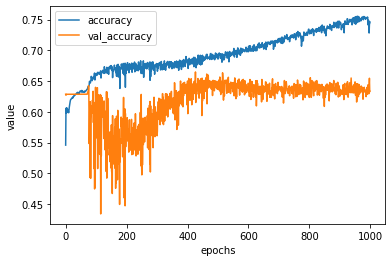

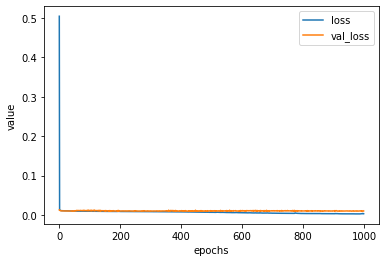

In [21]:
  plot_history(history)
  # plot_model(model)
  # model.save('1000.model')


**Checking out the results on custom images**

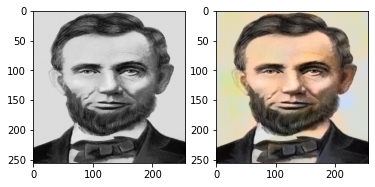

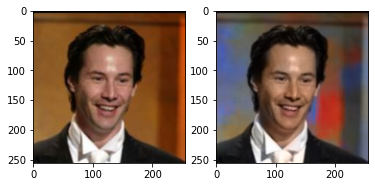

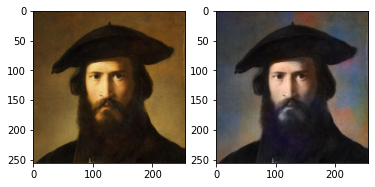

In [23]:
img_names = ['lincoln.png', 'keanu.jpg', 'keanu1530.jpg']

for img_name in img_names:
  img1_color=[]
  img1=img_to_array(load_img(img_name))
  img1 = resize(img1 ,(256,256))
  img1_color.append(img1)
  img1_color = np.array(img1_color, dtype=float)
  img1_color = rgb2lab(1.0/255*img1_color)[:,:,:,0]
  img1_color = img1_color.reshape(img1_color.shape+(1,))
  output1 = model.predict(img1_color)
  output1 = output1*128
  result = np.zeros((256, 256, 3))
  result[:,:,0] = img1_color[0][:,:,0]
  result[:,:,1:] = output1[0]
  img1 = cv.imread(img_name)
  img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
  img1 = cv.resize(img1, (256, 256))
  fig, ax = plt.subplots(1,2)
  ax[0].imshow(img1)
  ax[1].imshow(lab2rgb(result))
  plt.show()

**Summing up**

Results are rather good but not perfect. Plots show that network is overfitting, but don't know why it doesn't damage the result pictures a lot. Probably 450 epochs with this hyperparameters would be enough to train the net.

Next step must be checking out some autoencoder-based architectures like U-Net, Attention U-Net and so on.